In [1]:
import sys
sys.path.append('../code/functions')
sys.path.append('../../code/functions')

import glob
import numpy as np
import tiffIO as io
import scipy.io as sio
import neuroGraphLib as ngl
import matplotlib.pyplot as plt

from scipy import ndimage
from cluster import Cluster
from scipy.signal import convolve
from neuroGraphLib import neuroGraph
from skimage.exposure import equalize_adapthist
from scipy.ndimage.filters import convolve

In [4]:
procData = []
for mat in glob.glob('collman15v2/*_p1.mat'):
    name = mat[12:-7]
    rawData = sio.loadmat(mat)
    npData = np.rollaxis(rawData[name], 2, 0)
    procData.append([name, npData])


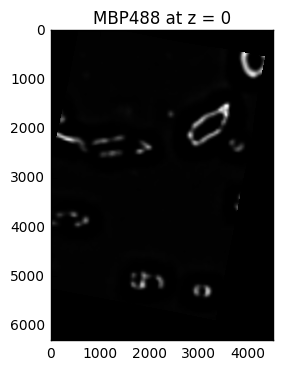

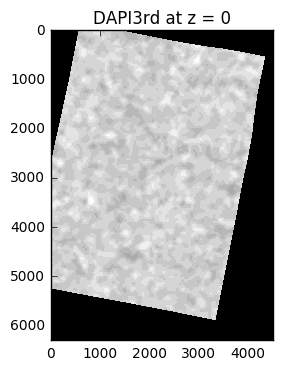

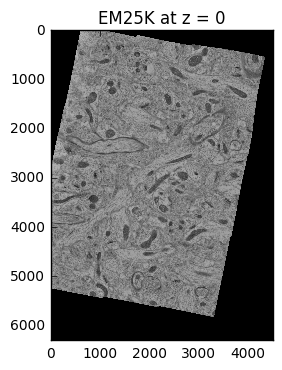

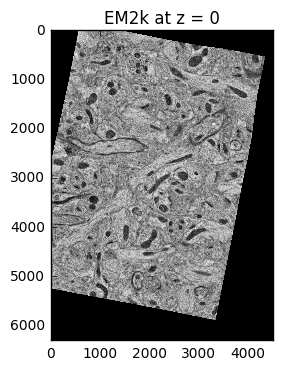

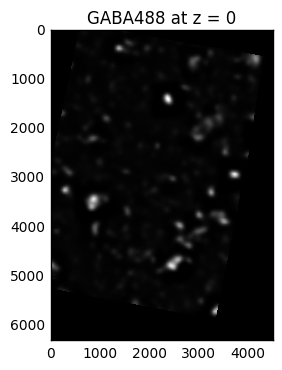

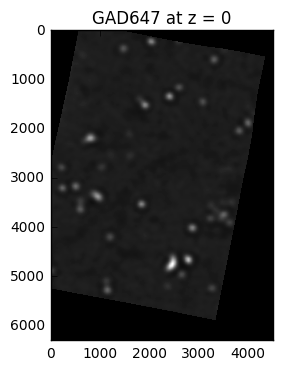

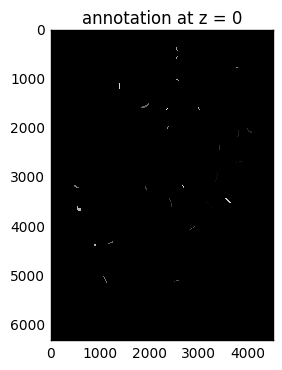

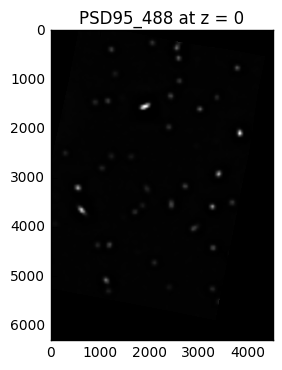

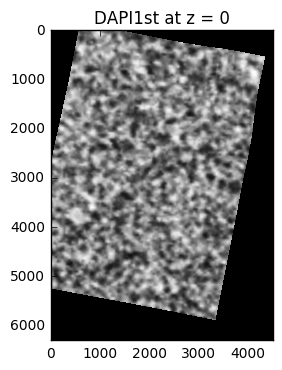

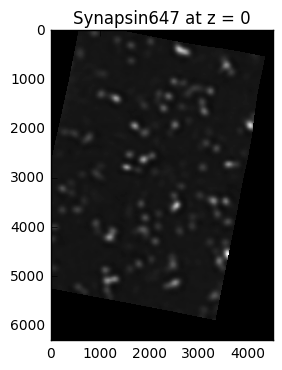

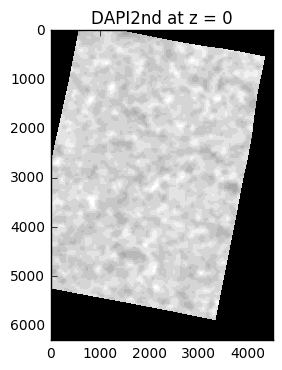

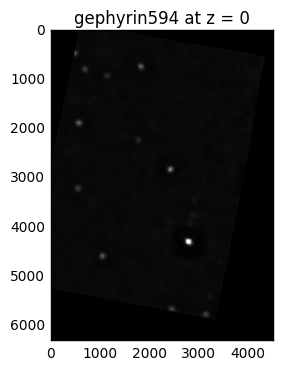

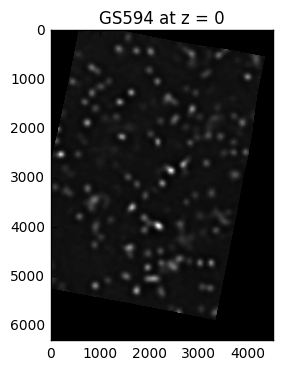

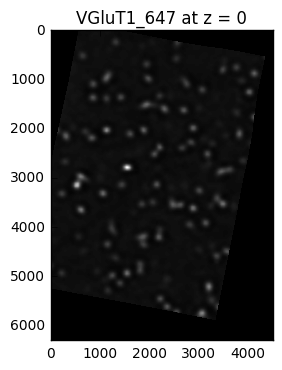

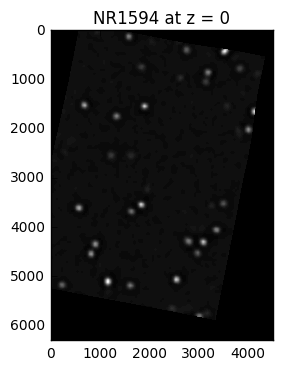

In [5]:
for dataSet in procData:
    plt.figure()
    plt.imshow(dataSet[1][0], cmap='gray')
    plt.title(str(dataSet[0]) + ' at z = 0')
    plt.show()

Looks like the PSD chan will give us the best results. Let's take a look at what we got

# Pipeline v1.0

In [4]:
import connectLib as cLib
print procData[7][0]
data = procData[7][1]
print data.shape


PSD95_488
(9, 6306, 4518)


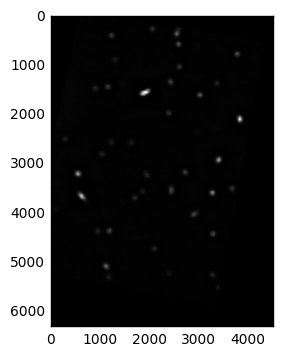

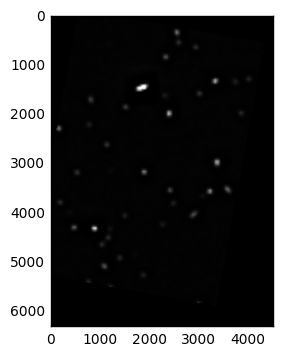

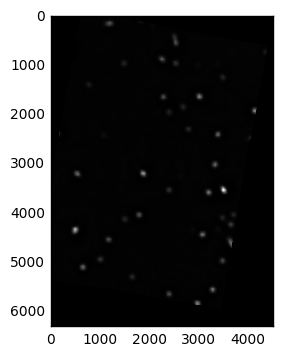

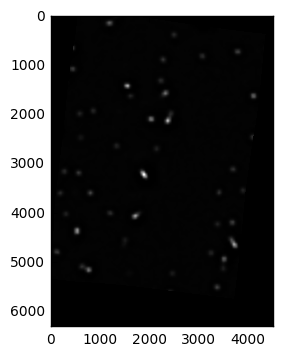

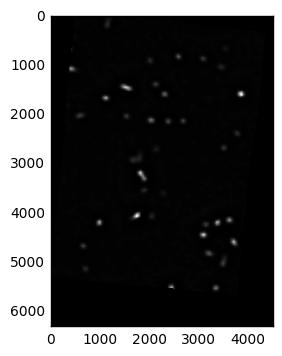

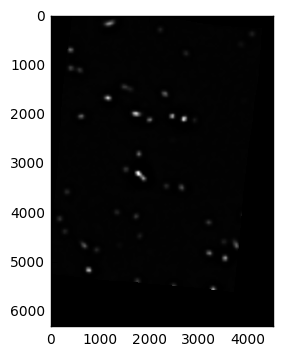

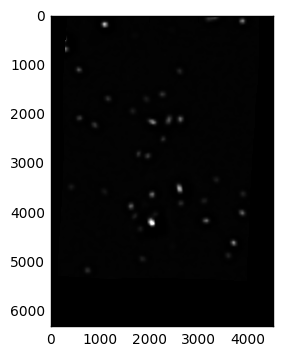

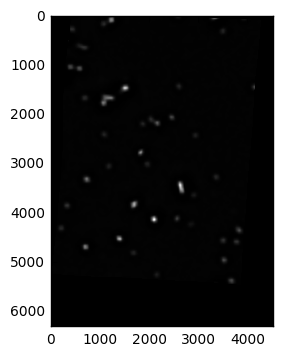

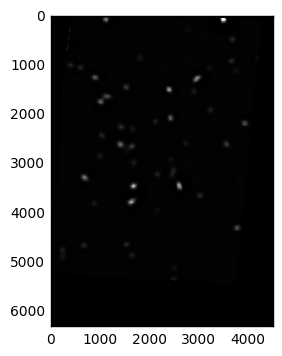

In [5]:
for i in range(data.shape[0]):
    plt.figure()
    plt.imshow(data[i], cmap='gray')
    plt.show()

## 1. Adaptive

In [6]:
adaptiveOut = cLib.otsuVox(data)

Nonzero:  169702


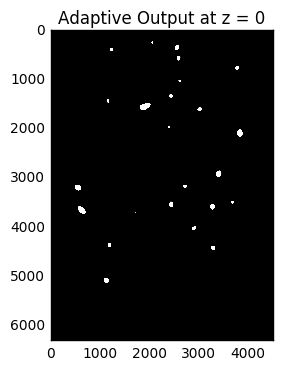





Nonzero:  122339


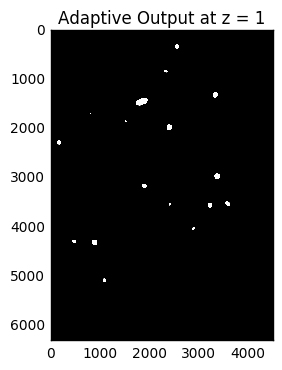





Nonzero:  259767


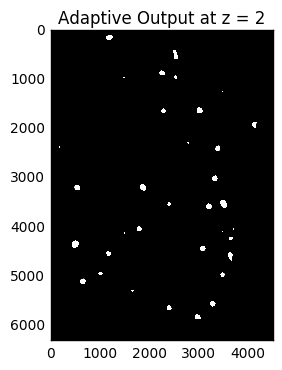





Nonzero:  210762


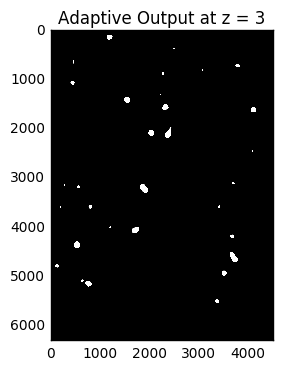





Nonzero:  206305


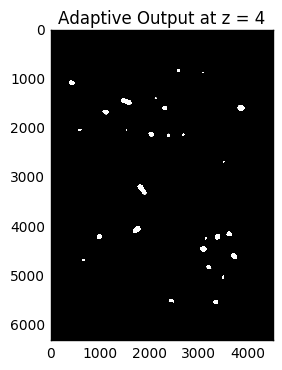





Nonzero:  198510


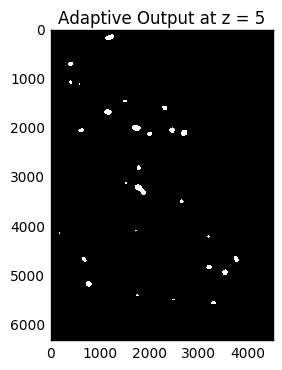





Nonzero:  156022


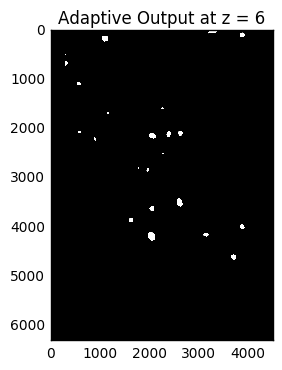





Nonzero:  196969


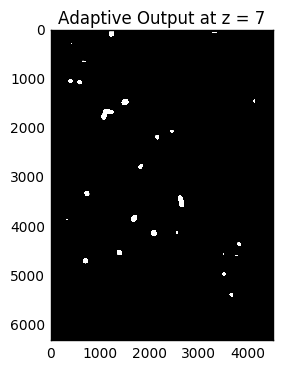





Nonzero:  169741


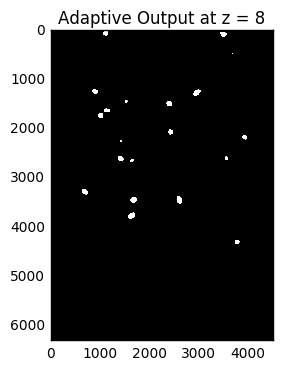

In [7]:
for i in range(0, data.shape[0]):
    plt.figure()
    plt.imshow(adaptiveOut[i], cmap='gray')
    print 'Nonzero: ' ,np.count_nonzero(adaptiveOut[i])
    plt.title('Adaptive Output at z = '+str(i))
    plt.show()
    print '\n\n\n'

## 2. Connected Component Analysis

In [9]:
def knn_fast(imgStack, n):
    kernel = np.stack([[0, 1, 0],[1, 0, 1], [0, 1, 1]])
    out = []
    
    for idx, img in enumerate(imgStack):
        print idx/float(imgStack.shape[0])
        conImg = convolve(img, kernel)
        out.append(conImg >=n)
    return np.stack(out)

In [13]:
knnOut = knn_fast(adaptiveOut, 2)

0.0
0.111111111111
0.222222222222
0.333333333333
0.444444444444
0.555555555556
0.666666666667
0.777777777778
0.888888888889


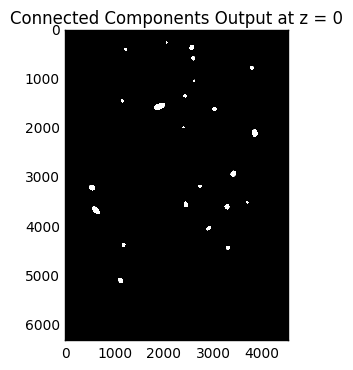

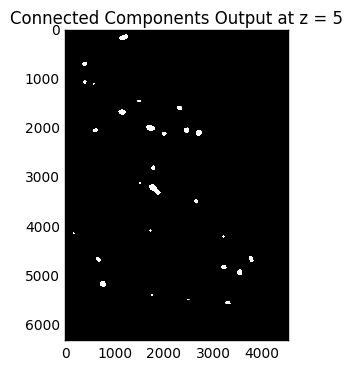

In [14]:
for i in range(0, data.shape[0], 5):
    plt.figure()
    plt.imshow(knnOut[i], cmap='gray')
    plt.title('Connected Components Output at z = '+str(i))
    plt.show()

## 3 Cluster Extraction

In [15]:
s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]
connectionImg, nr_objects = ndimage.label(knnOut, s)

In [42]:
synapseLists = cLib.clusterThresh(connectionImg, 0, 100000)

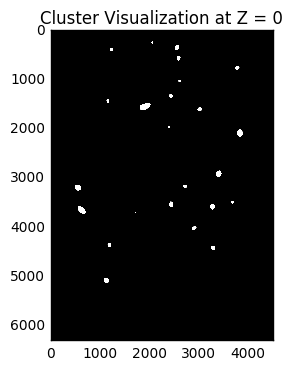

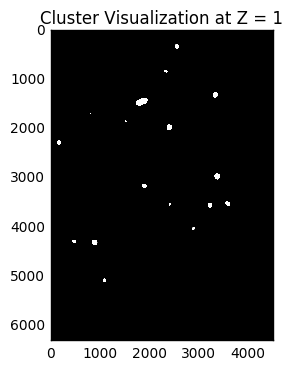

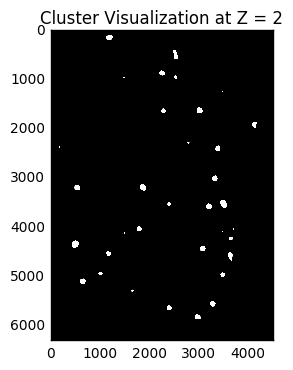

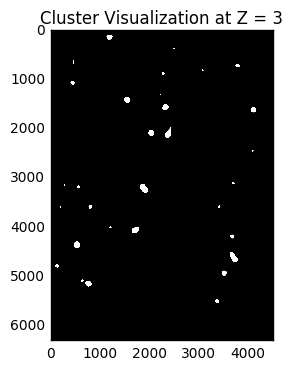

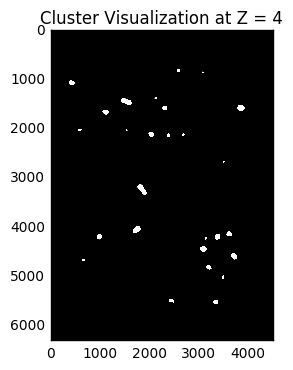

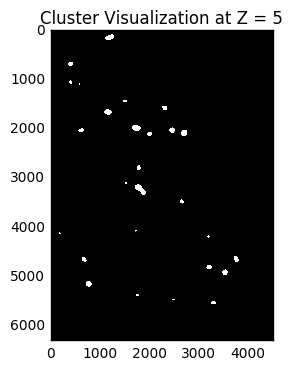

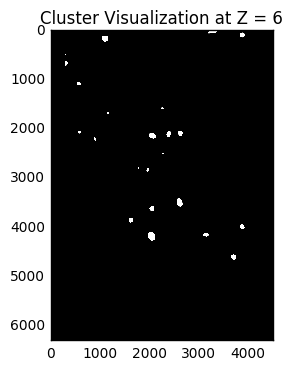

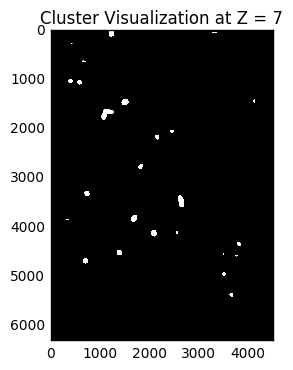

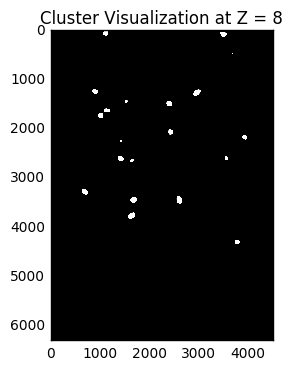

In [43]:
clusterVis = np.zeros_like(data)
for synapse in synapseLists:
    for member in synapse.members:
        clusterVis[member[0]][member[1]][member[2]] = 1

for i in range(0, clusterVis.shape[0]):
    plt.figure()
    plt.imshow(clusterVis[i], cmap='gray')
    plt.title('Cluster Visualization at Z = ' + str(i))
    plt.show()

# Labels

In [44]:
def precision_recall_f1(labels, predictions, overlapRatio):
   

    if len(predictions) == 0:
        print 'ERROR: prediction list is empty'
        return 0., 0., 0.
    
    labelFound = np.zeros(len(labels))
    truePositives = 0
    falsePositives = 0

    for prediction in predictions:
        #casting to set is ok here since members are uinque
        predictedMembers = set([tuple(elem) for elem in prediction.getMembers()])
        detectionCutoff = overlapRatio * len(predictedMembers)
        found = False
        
        for idx, label in enumerate(labels):
            labelMembers = set([tuple(elem) for elem in label.getMembers()])
            #if the predictedOverlap is over the detectionCutoff ratio
            if len(predictedMembers & labelMembers) >= detectionCutoff:
                truePositives +=1
                found=True
                labelFound[idx] = 1
        
        if not found:
            falsePositives +=1
            
    precision = truePositives/float(truePositives + falsePositives)
    recall = np.count_nonzero(labelFound)/float(len(labels))
    f1 = 0
    try:
        f1 = 2 * (precision*recall)/(precision + recall)
        
    except ZeroDivisionError:
        f1 = 0
        
    return precision, recall, f1

In [45]:
annotations = sio.loadmat('collman15v2/annotation_p1.mat')['annotation']
annotations = np.rollaxis(annotations, 2, 0)
print annotations.shape

(9, 6306, 4518)


In [46]:
clusterLabels = cLib.clusterThresh(cLib.otsuVox(annotations), 0, 10000000)

In [47]:
precision_recall_f1(clusterLabels, synapseLists, .05)

(0.35714285714285715, 0.5714285714285714, 0.43956043956043955)

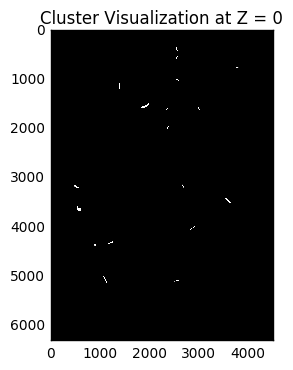

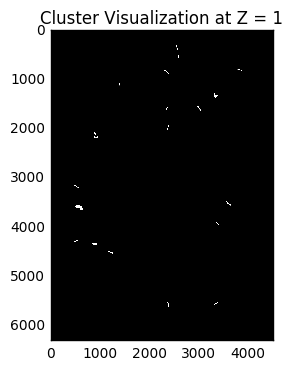

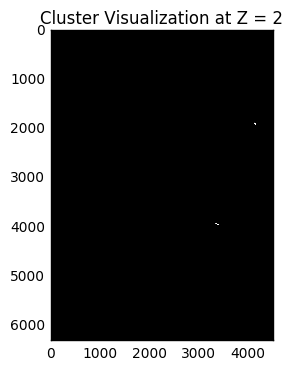

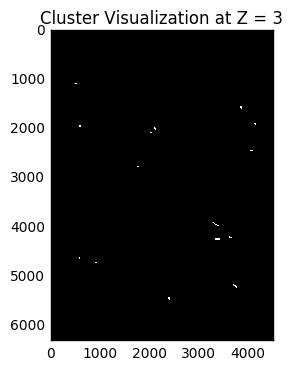

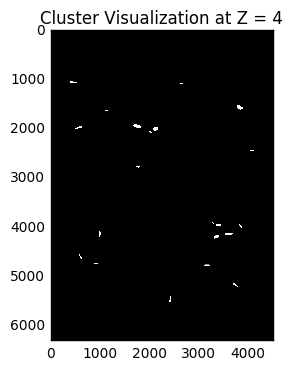

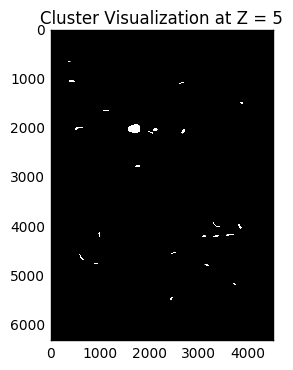

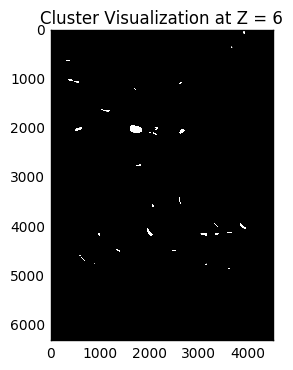

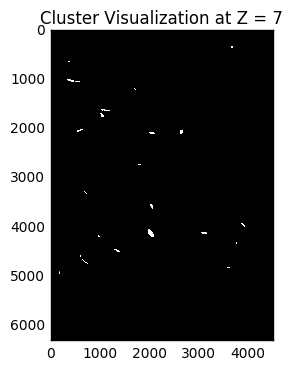

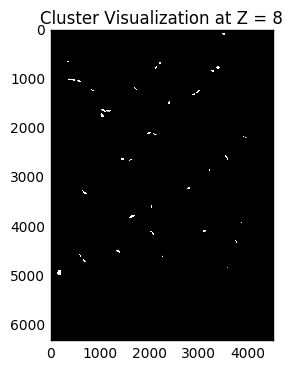

In [41]:
clusterVis = np.zeros_like(data)
for synapse in clusterLabels:
    for member in synapse.members:
        clusterVis[member[0]][member[1]][member[2]] = 1

for i in range(0, clusterVis.shape[0]):
    plt.figure()
    plt.imshow(clusterVis[i], cmap='gray')
    plt.title('Cluster Visualization at Z = ' + str(i))
    plt.show()